Reloading Tuner from hyperparam_tuning/wearable_data/tuner0.json
860/860 [==============================] - 6s 7ms/step

Overall Test Accuracy: 0.8580670356750488
Fold 1 Test Accuracy: 0.8563
Fold 2 Test Accuracy: 0.8566
Fold 3 Test Accuracy: 0.8591
Fold 4 Test Accuracy: 0.8580
Fold 5 Test Accuracy: 0.8588
Fold 6 Test Accuracy: 0.8597
Overall Test Accuracy: 0.8581
Average Precision Score: 0.8603
Average Recall Score: 0.8581
Average F1 Score: 0.8574


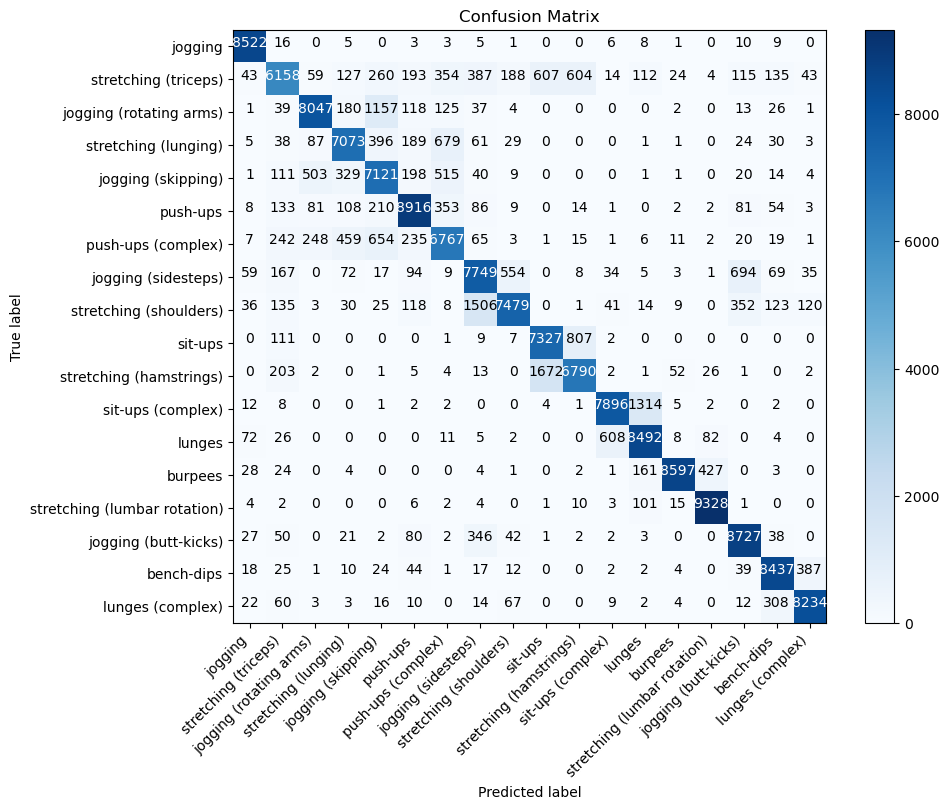

In [5]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix # For performance evaluation
import numpy as np # For numerical operations
import pandas as pd  # For data manipulation and analysis
import random # For random operations

# Import necessary components from scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder # For scaling features and encoding labels
from sklearn.model_selection import StratifiedKFold # For stratified cross-validation
from sklearn.utils.class_weight import compute_class_weight # For computing class weights to handle imbalances

# Import necessary components from Keras
from keras.utils import to_categorical  # For converting labels to one-hot encoding
from keras.models import Model # For defining the model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, GRU, Dropout, Reshape, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Bidirectional, BatchNormalization # For defining model layers
from keras.callbacks import EarlyStopping # For early stopping during training
from keras.optimizers import Adam # For optimization
from keras.regularizers import l2 
import keras_tuner as kt
import matplotlib.pyplot as plt # For plotting

# Labels for the activities
labels = ['jogging', 'stretching (triceps)', 'jogging (rotating arms)',
          'stretching (lunging)', 'jogging (skipping)', 'push-ups',
          'push-ups (complex)', 'jogging (sidesteps)',
          'stretching (shoulders)', 'sit-ups', 'stretching (hamstrings)',
          'sit-ups (complex)', 'lunges', 'burpees',
          'stretching (lumbar rotation)', 'jogging (butt-kicks)',
          'bench-dips', 'lunges (complex)']

def load_and_preprocess_single_csv(csv_file, scaler=None, label_encoder=None, fit_scaler=False, fit_label_encoder=False):
    # Load the data from the CSV file
    data = pd.read_csv(csv_file)
    
    # Clean the data: drop rows with NaN values in 'label' and interpolate remaining NaNs
    data = data.dropna(subset=['label'])
    data = data.interpolate(method='linear', limit_direction='forward', axis=0).dropna()
    
    # Separate features (X) and labels (y)
    X = data.drop(['sbj_id', 'label'], axis=1).values
    y = data['label'].values
    
    # Fit or transform the features using the scaler
    if fit_scaler:
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    
    # Fit or transform the labels using the label encoder and convert to one-hot encoding
    if fit_label_encoder:
        y = to_categorical(label_encoder.fit_transform(y))
    else:
        y = to_categorical(label_encoder.transform(y))
    
    return X, y

def build_model(hp, input_dim, num_classes):
    # Define the input shape
    input_shape = (10, input_dim)  # Assume at least 10 time steps for Conv1D to work properly
    
    input_layer = Input(shape=input_shape)
    # Hyperparameters for tuning
    conv_filters = hp.Int('conv_filters', min_value=32, max_value=128, step=32)
    kernel_size = hp.Int('kernel_size', min_value=1, max_value=3, step=1)
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    gru_units = hp.Int('gru_units', min_value=64, max_value=256, step=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    l2_reg = hp.Float('l2_reg', min_value=0.01, max_value=0.1, step=0.01)

    # Convolutional layer
    cnn_out = Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_reg))(input_layer)
    cnn_out = BatchNormalization()(cnn_out)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)  # Use pooling size 2
    cnn_out = Flatten()(cnn_out)
    cnn_out = Dense(100, activation='relu', kernel_regularizer=l2(l2_reg))(cnn_out)
    cnn_out = Dropout(dropout_rate)(cnn_out)

    # Reshape for LSTM input
    reshaped_cnn_out = Reshape((1, 100))(cnn_out)

    # Bidirectional LSTM layer
    lstm_out = Bidirectional(LSTM(lstm_units, activation='relu', return_sequences=True))(reshaped_cnn_out)
    lstm_out = Dropout(dropout_rate)(lstm_out)

    # Bidirectional GRU layer
    gru_out = Bidirectional(GRU(gru_units, activation='relu', return_sequences=True))(lstm_out)
    gru_out = Dropout(dropout_rate)(gru_out)

    # Transformer encoder layer
    def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout=0.1):
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
        attention_output = Dropout(dropout)(attention_output)
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

        ff_output = Dense(ff_dim, activation='relu')(attention_output)
        ff_output = Dropout(dropout)(ff_output)
        ff_output = Dense(inputs.shape[-1])(ff_output)
        encoder_output = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)
        
        return encoder_output

    # Apply transformer encoder
    transformer_out = transformer_encoder(gru_out, num_heads=4, key_dim=128, ff_dim=256, dropout=dropout_rate)
    transformer_out = GlobalAveragePooling1D()(transformer_out)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(transformer_out)

    # Compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def train_and_evaluate(csv_files, n_splits=6, max_trials=10, executions_per_trial=1):
    random.shuffle(csv_files)
    all_X = []
    all_y = []

    # Load all data for cross-validation
    scaler = StandardScaler()
    label_encoder = LabelEncoder()
    for csv_file in csv_files:
        X, y = load_and_preprocess_single_csv(csv_file, scaler, label_encoder, fit_scaler=True, fit_label_encoder=True)
        all_X.append(X)
        all_y.append(y)
    
    all_X = np.concatenate(all_X, axis=0)
    all_y = np.concatenate(all_y, axis=0)

    # Ensure we have enough time steps
    time_steps = 10
    if all_X.shape[0] % time_steps != 0:
        pad_size = time_steps - (all_X.shape[0] % time_steps)
        all_X = np.pad(all_X, ((0, pad_size), (0, 0)), mode='constant')
        all_y = np.pad(all_y, ((0, pad_size), (0, 0)), mode='constant')

    all_X = all_X.reshape(-1, time_steps, all_X.shape[1])
    all_y = all_y.reshape(-1, time_steps, all_y.shape[1])
    all_y = all_y[:, 0, :]  # Use the first label of each sequence

    # Define the tuner
    tuner = kt.RandomSearch(
        hypermodel=lambda hp: build_model(hp, input_dim=all_X.shape[2], num_classes=all_y.shape[1]),
        objective='val_accuracy',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='hyperparam_tuning',
        project_name='wearable_data'
    )

    # Cross-validation
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    test_accuracies = []
    all_predictions = []
    all_true_labels = []
    for train_index, test_index in kf.split(all_X, np.argmax(all_y, axis=1)):
        X_train, X_test = all_X[train_index], all_X[test_index]
        y_train, y_test = all_y[train_index], all_y[test_index]

        # Compute class weights to handle class imbalance
        class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
        class_weights = {i: weight for i, weight in enumerate(class_weights)}

        # Early stopping callback
        stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Hyperparameter tuning
        tuner.search(X_train, y_train, epochs=150, batch_size=64, validation_split=0.2, callbacks=[stop_early], class_weight=class_weights)

        # Get the best model
        best_model = tuner.get_best_models(num_models=1)[0]

        # Evaluate the best model
        _, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
        test_accuracies.append(test_accuracy)

        # Make predictions
        y_pred = np.argmax(best_model.predict(X_test), axis=1)
        all_predictions.append(y_pred)
        all_true_labels.append(np.argmax(y_test, axis=1))

    # Compute overall accuracy
    overall_accuracy = np.mean(test_accuracies)

    # Flatten predictions for classification report
    all_predictions = np.concatenate(all_predictions)
    all_true_labels = np.concatenate(all_true_labels)

    # Compute metrics
    average_f1 = f1_score(all_true_labels, all_predictions, average='weighted')
    average_recall = recall_score(all_true_labels, all_predictions, average='weighted')
    average_precision = precision_score(all_true_labels, all_predictions, average='weighted')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)

    print("\nOverall Test Accuracy:", overall_accuracy)
    for i, test_accuracy in enumerate(test_accuracies):
        print(f"Fold {i + 1} Test Accuracy: {test_accuracy:.4f}")
    print(f"Overall Test Accuracy: {overall_accuracy:.4f}")
    print(f"Average Precision Score: {average_precision:.4f}")
    print(f"Average Recall Score: {average_recall:.4f}")
    print(f"Average F1 Score: {average_f1:.4f}")

    # Plot label matrix with annotations
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # Add numerical annotations
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > np.max(conf_matrix) / 2. else "black")
    # Plotting the confusion matrix
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right') 
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Loading the files
if __name__ == "__main__":
    # List of all CSV files
    csv_files = [
        'data/wear/raw/inertial/sbj_0.csv',
        'data/wear/raw/inertial/sbj_1.csv',
        'data/wear/raw/inertial/sbj_2.csv',
        'data/wear/raw/inertial/sbj_3.csv',
        'data/wear/raw/inertial/sbj_4.csv',
        'data/wear/raw/inertial/sbj_5.csv',
        'data/wear/raw/inertial/sbj_6.csv',
        'data/wear/raw/inertial/sbj_7.csv',
        'data/wear/raw/inertial/sbj_8.csv',
        'data/wear/raw/inertial/sbj_9.csv',
        'data/wear/raw/inertial/sbj_10.csv',
        'data/wear/raw/inertial/sbj_11.csv',
        'data/wear/raw/inertial/sbj_12.csv',
        'data/wear/raw/inertial/sbj_13.csv',
        'data/wear/raw/inertial/sbj_14.csv',
        'data/wear/raw/inertial/sbj_15.csv',
        'data/wear/raw/inertial/sbj_16.csv',
        'data/wear/raw/inertial/sbj_17.csv',
    ]

    # Perform training and testing with different hyperparameters
    train_and_evaluate(csv_files, n_splits=6, max_trials=10, executions_per_trial=1)
